In [15]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# **Data Loading**

In [0]:
import pandas as pd
data = pd.read_csv("multi_hot_data_main.csv")

In [0]:
data["len"] = data["para"].str.split().str.len()

In [3]:
data.shape

(25000, 29)

In [4]:
data["len"].max()

6192

In [5]:
data["len"].min()

0

In [0]:
sample = data[(data['len'] >= 10) & (data['len'] <=1000)]

In [7]:
sample.head()

,persons covered treaty eligibility,pe,business profits,shipping air transport,interest,royalty,royaltyfts,fts,independent personal services,dividend,capital gains,other treaty issues,gaar,income not includible in total income,profits gains from business profession,other sources,unexplained income,chapter via deductions,minimum alternate tax,prosecution,interest (interest on income tax refund),carry forward of losses,penalty,dispute resolution,section 9,refund processing section 143(1d),dividend distribution tax,para,len
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,consequently the forex loss was allowed as cla...,29
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,there is no document whatsoever to show that t...,65
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3 the ld cit(a) has erred in law and on facts...,32
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4 af ter hearing the learned representatives ...,63
4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,8 section 36 (1)(iii) of the income tax act 1...,202


In [6]:
sample.shape

(24664, 29)

# **Importing Relevant Dependencies**

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Model, load_model 
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout, Conv1D,Dense, Embedding, Input, GRU, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.optimizers import Adam, RMSprop
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from sklearn import metrics
from sklearn.model_selection import train_test_split

# **Splitting Data**

In [0]:
train, test = train_test_split(sample,test_size=0.2,random_state=123)

In [10]:
print(train.shape)
print(test.shape)

(19731, 29)
(4933, 29)


In [0]:
features_train = train.iloc[:,-2]
features_test = test.iloc[:,-2]

In [11]:
features_train

3310     6 for the proposition that on a mere differenc...
5553     11 the learned cit (dr) countering the submiss...
9363     4 on query by the bench assessee has filed rec...
1382      18 in substance the contention of the learned...
5528     13 the next gift deed available on pages 50 an...
                               ...                        
15590     32 sec 18 of the indian partnership act runs ...
21899    4 learned counsel for the appellant submits th...
17976     18 on these facts the question posed before t...
15944    5 now we take the appeals filed by the assesse...
20242     13 he pointed out that the ito referred to th...
Name: para, Length: 19731, dtype: object

In [0]:
y_train = train.iloc[:,1:-2].values
y_test = test.iloc[:,1:-2].values

In [13]:
y_train.shape

(19731, 26)

# **Data Preparation**

In [16]:
# load in pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open("drive/My Drive/ content glove glove.42B.300d.txt") as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))


Loading word vectors...
Found 1917494 word vectors.


In [0]:
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 300

In [0]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(features_train)
sequences_train = tokenizer.texts_to_sequences(features_train)
sequences_test = tokenizer.texts_to_sequences(features_test)

In [21]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 105026 unique tokens.


In [0]:
length = []

for i in sequences_train:

  length.append(len(i))

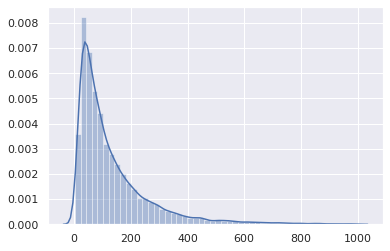

In [23]:
sns.set()
sns.distplot(length)

In [0]:
MAX_SEQUENCE_LENGTH = 200

In [25]:
encoded_train = pad_sequences(sequences_train,maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', encoded_train.shape)
encoded_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', encoded_test.shape)

Shape of data tensor: (19731, 200)
Shape of data tensor: (4933, 200)


In [27]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
        embedding_matrix[i] = embedding_vector

print(embedding_matrix.shape)

Filling pre-trained embeddings...
(20000, 300)


# **Model Building**

In [30]:
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)



print('Building model...')

# create an LSTM network with a single LSTM
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Bidirectional(GRU(128, return_sequences=True, dropout=0.1,
                                                      recurrent_dropout=0.1))(x)
 
x = Conv1D(64, kernel_size=3, padding="valid", kernel_initializer="glorot_uniform")(x)
 
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
 
x = concatenate([avg_pool, max_pool])
 
preds = Dense(26, activation="sigmoid")(x)
 
model = Model(input_, preds)
 
model.summary()
 
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-3), metrics=['accuracy'])

Building model...
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 200, 300)     6000000     input_3[0][0]                    
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 200, 256)     329472      embedding_3[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 198, 64)      49216       bidirectional_3[0][0]            
__________________________________________________________________________

In [0]:
# Callbacks
model_3 = ModelCheckpoint('model_bilstm_multilabel_2.h5', save_best_only=True, monitor='val_loss', mode='min')
logdir = "logs/model_bilstm_multilabel/"
tensorboard_callback = TensorBoard(log_dir=logdir)

In [33]:
print('Training model...')
r = model.fit(
  encoded_train,
  y_train,
  batch_size=512,
  epochs=10,
  validation_data=(encoded_test,y_test),callbacks=[tensorboard_callback,model_3]
)

Training model...


Train on 19731 samples, validate on 4933 samples


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'
Epoch 1/10
19731/19731 [==============================] - 42s 2ms/step - loss: 0.2489 - acc: 0.9019 - val_loss: 0.1794 - val_acc: 0.9238

Epoch 2/10
19731/19731 [==============================] - 36s 2ms/step - loss: 0.1732 - acc: 0.9284 - val_loss: 0.1722 - val_acc: 0.9282
Epoch 3/10
19731/19731 [==============================] - 36s 2ms/step - loss: 0.1657 - acc: 0.9311 - val_loss: 0.1642 - val_acc: 0.9312
Epoch 4/10
19731/19731 [==============================] - 36s 2ms/step - loss: 0.1566 - acc: 0.9346 - val_loss: 0.1535 - val_acc: 0.9357
Epoch 5/10
19731/19731 [==============================] - 36s 2ms/step - loss: 0.1460 - acc: 0.9398 - val_loss: 0.1431 - val_acc: 0.9415
Epoch 6/10
19731/19731 [==============================] - 36s

# **Results Analysis**

In [0]:
predictions_3 = model.predict(encoded_test)

In [36]:
for thresh in np.arange(0.3, 0.601, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(y_test, (predictions_3>thresh).astype(int),average="micro")))

F1 score at threshold 0.3 is 0.6520915318466697
F1 score at threshold 0.31 is 0.653190020708017
F1 score at threshold 0.32 is 0.6558016297555366
F1 score at threshold 0.33 is 0.6572370088719898
F1 score at threshold 0.34 is 0.6576243321002877
F1 score at threshold 0.35 is 0.658753709198813
F1 score at threshold 0.36 is 0.6593835761030188
F1 score at threshold 0.37 is 0.6606770415530242
F1 score at threshold 0.38 is 0.6610380473020512
F1 score at threshold 0.39 is 0.6601389420710027
F1 score at threshold 0.4 is 0.659727604916399
F1 score at threshold 0.41 is 0.6593468153044648
F1 score at threshold 0.42 is 0.6584427342689
F1 score at threshold 0.43 is 0.6577935861396361
F1 score at threshold 0.44 is 0.6583966146890036
F1 score at threshold 0.45 is 0.65760965040698
F1 score at threshold 0.46 is 0.6570785984848485
F1 score at threshold 0.47 is 0.6544390010753972
F1 score at threshold 0.48 is 0.6526493867440034
F1 score at threshold 0.49 is 0.6509981075636407
F1 score at threshold 0.5 is 0

In [38]:
for thresh in np.arange(0.6, 0.901, 0.01):
    thresh = np.round(thresh, 2)
    print("Precision score at threshold {0} is {1}".format(thresh, metrics.precision_score(y_test, (predictions_3>thresh).astype(int),average="micro")))

Precision score at threshold 0.6 is 0.8443516164184526
Precision score at threshold 0.61 is 0.8487426035502958
Precision score at threshold 0.62 is 0.8536447541909964
Precision score at threshold 0.63 is 0.8574990410433448
Precision score at threshold 0.64 is 0.8623655913978494
Precision score at threshold 0.65 is 0.8678906405907004
Precision score at threshold 0.66 is 0.8712306438467807
Precision score at threshold 0.67 is 0.8740679370339686
Precision score at threshold 0.68 is 0.8773226351351351
Precision score at threshold 0.69 is 0.8811987925830099
Precision score at threshold 0.7 is 0.8868007959319036
Precision score at threshold 0.71 is 0.8904697380307136
Precision score at threshold 0.72 is 0.8955361251725725
Precision score at threshold 0.73 is 0.8991063029162747
Precision score at threshold 0.74 is 0.9025444071051368
Precision score at threshold 0.75 is 0.9096948818897638
Precision score at threshold 0.76 is 0.9123958596314062
Precision score at threshold 0.77 is 0.91591203104

In [39]:
for thresh in np.arange(0.6, 0.901, 0.01):
    thresh = np.round(thresh, 2)
    print("Recall score at threshold {0} is {1}".format(thresh, metrics.recall_score(y_test, (predictions_3>thresh).astype(int),average="micro")))

Recall score at threshold 0.6 is 0.4873676486004822
Recall score at threshold 0.61 is 0.4811825138903449
Recall score at threshold 0.62 is 0.47510221197190483
Recall score at threshold 0.63 is 0.468707411678373
Recall score at threshold 0.64 is 0.4624174441765384
Recall score at threshold 0.65 is 0.45591781109130936
Recall score at threshold 0.66 is 0.44826501729741064
Recall score at threshold 0.67 is 0.44239438096236505
Recall score at threshold 0.68 is 0.4355802495020442
Recall score at threshold 0.69 is 0.4284516196666317
Recall score at threshold 0.7 is 0.42048432749764125
Recall score at threshold 0.71 is 0.41335569766222874
Recall score at threshold 0.72 is 0.40800922528566935
Recall score at threshold 0.73 is 0.4007757626585596
Recall score at threshold 0.74 is 0.3941712967816333
Recall score at threshold 0.75 is 0.387566830904707
Recall score at threshold 0.76 is 0.37886570919383583
Recall score at threshold 0.77 is 0.37110808260823985
Recall score at threshold 0.78 is 0.36188